# <center>  Соревнование Kaggle "Catch Me If You Can"

## 1. Цели, задачи, данные
Решается задача идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. Построенный нами алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).
    
Задаче ценна тем, что очень часто возникает на практике для предотвращения несанкционированного доступа к электронной почте людей. Настроенный алгоритм на конкретного человека - настоящего пользователя, уже знает его привычки, а новых людей (взломщиков) нет, поэтому может из выбросить с почтового ящика

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [2]:
PATH_TO_DATA = 'alice_identification'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
train_df.columns

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')

Как видим, занные состоят из 10 сайтов и времени их посещений. Максимальная сессия составляет 10 сайтов или 30 минут с времени открытия первого сайта. 
Поскольку данные содержат "время", будем использовать валидационную схему по времени. Для корректной валидации отсортируем данные в трейне по времени открытия первого сайта.

In [6]:
train_df.sort_values(by='time1', inplace=True)

**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату и добавить новые признаки в пространство теста.**

In [7]:
train_test_df = pd.concat([train_df, test_df])

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: flo

In [9]:
train_df.shape

(253561, 21)

In [10]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [12]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

## 2. Feature engineering

Поскольку последовательность сайтов в списке из 10 можно представить в виде конкретного вектора в пространстве, то было бы неплохо рассматривать не только частоты сайтов, но и похожесть этих векторов друг на друга. Запишем матрицы сайтов в файлы.

In [13]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

Воспользуемся стандартной утилитой CountVectorizer для построения разреженной матрицы для сайтов. Что бы добавить собственные новые признаки необходимо создавать разреженную матрицу вручную.

In [14]:
def sparce_matrix(A):
    docs = A.values
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            index = vocabulary.setdefault(term, term)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    X_sparce = csr_matrix((data, indices, indptr))
    return X_sparce

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

Построим разреженные матрицы для сайтов

In [16]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_text = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_text = cv.transform(inp_test_file)

Wall time: 40.7 s


Поскольку несколько сайтов встречается в сессии достаточно часто, планируется ввести признак отвечающий за самый частый сайт в сессии и признак за вхождение этого частого сайта в топ20 сайтов по общему посещению всеми пользователями. Для создания вспомогательного датафрейма используем словарь сайтов из соревнования.

In [17]:
hosts = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name'])

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True)
hosts.head()

,name,len,domain
site1,,,
25075,www.abmecatronique.com,3,com
13997,groups.live.com,3,com
42436,majeureliguefootball.wordpress.com,3,com
30911,cdt46.media.tourinsoft.eu,4,eu
8104,www.hdwallpapers.eu,3,eu


Напишем функцию, что будет возвращать новый датафрейм с интересующими нас признаками

In [18]:
def feature_engineering(data_frame):
    data = data_frame.copy()
    data.fillna(0, inplace=True)
    
    
    ## самый популярный сайт в сессии, если вхождения уникальны - то первый по порядку сайт
    sites_columns = [col for col in data.columns if 'site' in col]
    data[sites_columns]=data[sites_columns].astype('int')
    max_freq_site = pd.Series([0], name='sess_popular')
    second = pd.Series([np.argmax(np.bincount(row)) for row in data[sites_columns].values],
                              name='sess_popular')
    max_freq_site = max_freq_site.append(second, ignore_index=True)
    data['sess_popular']=max_freq_site
    
    ## Совпадение с топ20, 1-да,0-нет
    data = pd.merge(data, hosts, how='left', on='site1')
    top20 = [s for s, freq in Counter(data.name).most_common(20)]
    dict_site = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
    dict_site = {id_site: name for name, id_site in zip(dict_site.keys(), dict_site.values())}
    

    temp = []
    for i in range(data.shape[0]):
        try:
            if dict_site[new_feature['sess_popular'][i]] in top20:
                temp.append(1)
            else:
                temp.append(0)
        except:
            temp.append(0)
    data['top20'] = temp
    
   
    ## Признаки на основании дат
    times_columns = [col for col in data.columns if 'time' in col]
    for col in times_columns:
        data[col]=data[col].apply(pd.Timestamp)
        
    data['hour'] = data['time1'].apply(lambda ts: ts.hour)
    data['month'] = data['time1'].apply(lambda ts: ts.month)
    data['year'] = data['time1'].apply(lambda ts: ts.year)
    data['week'] = data['time1'].apply(lambda ts: ts.week)
    data['week_day'] = data['time1'].apply(lambda ts: ts.dayofweek)
    data['month_year']=data['month']+data['year']*100
    data['weekend'] = [1 if day>=5 else 0 for day in data['week_day']]
    
    ## Длинна сессии
    data['durations']=[(max(row).view(np.int64)-row[0].view(np.int64))/10**9 for row in data[times_columns].values]
        
    ## Часть дня
    part_of_day = []
    for value in  data['hour']:
        if 7<=value<=11:
            part='0'
        elif 11<value<=18:
            part = '1'
        elif 18<value<23:
            part = '2'
        else :
            part = '3'
        part_of_day.append(part)
    data['day_part']=part_of_day
    
    ## разница между двумя переходами с сайта на сайт во времени
    for i,col in enumerate(times_columns[1:]):
        data[f'diff_{col}_{times_columns[i]}']=(data[col].view(np.int64)-data[times_columns[i]].view(np.int64)) / 10**9
        

    data.drop(times_columns, axis=1, inplace=True)
    data.drop([
#                 'target',
               'name',
               'site1',
                'site2',
                'site3',
                'site4',
                'site5',
                'site6',
                'site7',
                'site8',
                'site9',
                'site10',
#                'domain'
              ], axis=1, inplace=True)
        
    return data

In [19]:
new_feature = feature_engineering(train_test_df)

In [20]:
new_feature.columns

Index(['target', 'sess_popular', 'len', 'domain', 'top20', 'hour', 'month',
       'year', 'week', 'week_day', 'month_year', 'weekend', 'durations',
       'day_part', 'diff_time2_time1', 'diff_time3_time2', 'diff_time4_time3',
       'diff_time5_time4', 'diff_time6_time5', 'diff_time7_time6',
       'diff_time8_time7', 'diff_time9_time8', 'diff_time10_time9'],
      dtype='object')

## 3. Basic EDA

Проведем некоторое графическое исследование полученых данных

In [21]:
new_feature.head()

,target,sess_popular,len,domain,top20,hour,month,year,week,week_day,...,day_part,diff_time2_time1,diff_time3_time2,diff_time4_time3,diff_time5_time4,diff_time6_time5,diff_time7_time6,diff_time8_time7,diff_time9_time8,diff_time10_time9
0,0.0,3846,4,com,0,8,1,2013,2,5,...,0,0.0,-1.357978e+09,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,0.0,23,4,com,0,8,1,2013,2,5,...,0,0.0,1.784000e+03,2.0,-1.357982e+09,0.0,0.0,0.0,0.0,0.0
2,0.0,21,3,org,0,8,1,2013,2,5,...,0,1.0,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,1.0,0.0
3,0.0,616,3,com,0,8,1,2013,2,5,...,0,0.0,1.000000e+00,0.0,0.000000e+00,0.0,1.0,0.0,0.0,1.0
4,0.0,786,4,com,0,8,1,2013,2,5,...,0,0.0,0.000000e+00,1.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0


Будем строить графики распределений справа для Алисы, слева для остальных

In [22]:
other = new_feature[new_feature.loc[:,'target']==0]
alice = new_feature[new_feature.loc[:,'target']==1]

#### 1 Разбиение по частям дня 

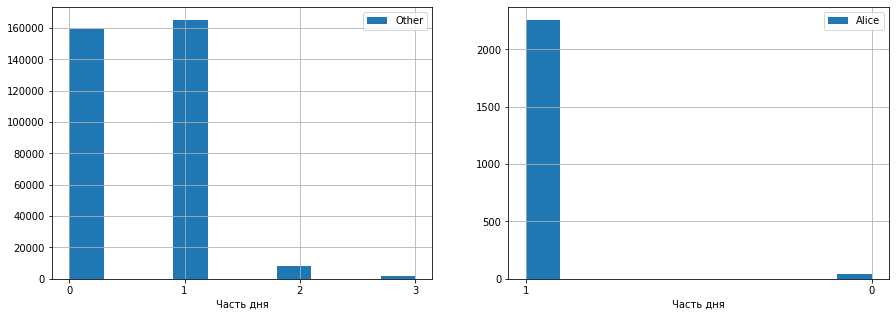

In [23]:
import matplotlib.pyplot as plt
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.day_part.hist(ax=ax1,label= 'Other')
ax1.set_xlabel('Часть дня')
alice.day_part.hist(ax=ax2, label= 'Alice')
ax2.set_xlabel('Часть дня')
ax1.legend()
ax2.legend()

#### 2 Разбиение по дням недели 

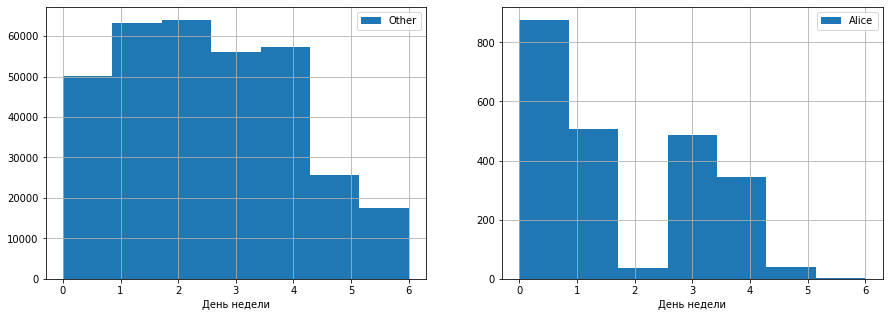

In [24]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.week_day.hist(ax=ax1, label='Other', bins=7)
alice.week_day.hist(ax=ax2, label='Alice', bins=7)
ax1.set_xlabel('День недели')
ax2.set_xlabel('День недели')
ax1.legend()
ax2.legend()

#### 3 Разбиение по часам начала сессии

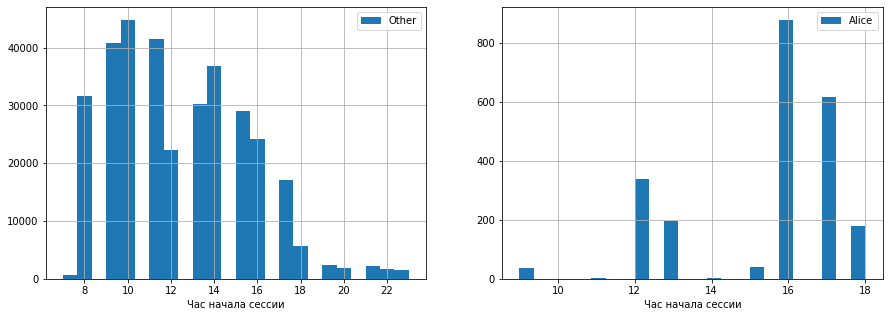

In [25]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.hour.hist(ax=ax1, label='Other', bins=24)
alice.hour.hist(ax=ax2, label='Alice', bins=24)
ax1.set_xlabel('Час начала сессии')
ax2.set_xlabel('Час начала сессии')
ax1.legend()
ax2.legend()

#### 4 Разбиение по признаку год - месяц

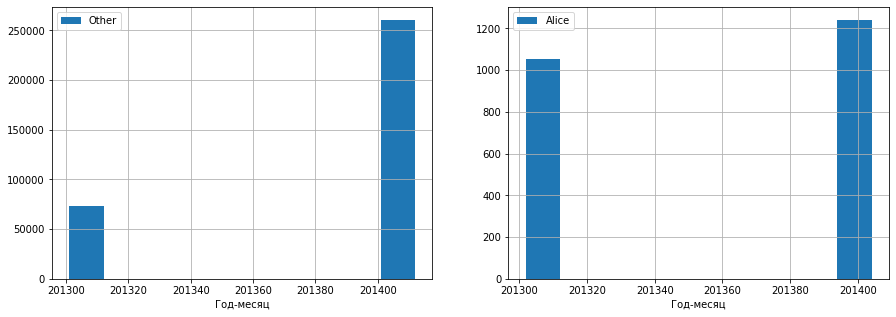

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.month_year.hist(ax=ax1, label='Other')
alice.month_year.hist(ax=ax2, label='Alice')
ax1.set_xlabel('Год-месяц')
ax2.set_xlabel('Год-месяц')
ax1.legend()
ax2.legend()

#### 5 Разбиение по длительности сессии

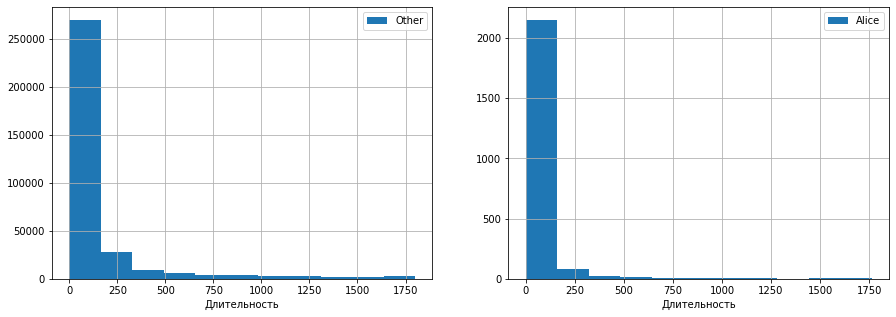

In [27]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.durations.hist(ax=ax1, label='Other', bins=11)
alice.durations.hist(ax=ax2, label='Alice', bins=11)
ax1.set_xlabel('Длительность')
ax2.set_xlabel('Длительность')
ax1.legend()
ax2.legend()

#### 6 Разбиение по доменам в посещенных сайтах

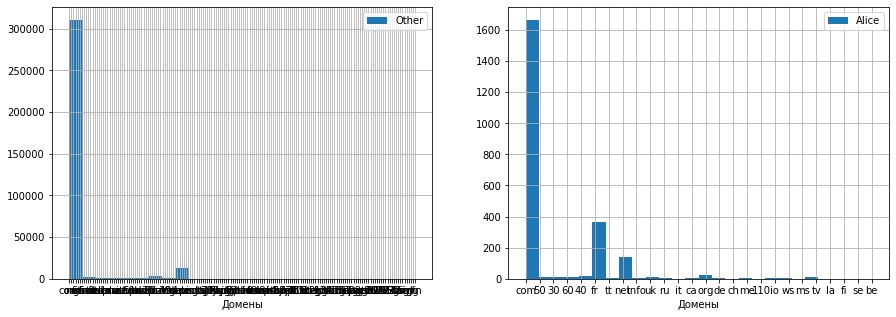

In [28]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.domain.hist(ax=ax1, label='Other', bins=26)
alice.domain.hist(ax=ax2, label='Alice', bins=26)
ax1.set_xlabel('Домены')
ax2.set_xlabel('Домены')
ax1.legend()
ax2.legend()

Посмотрим на наиболее популярные домены у взломщиков и нашей Алисы

In [29]:
alice.domain.value_counts()[:5]

com    1665
fr      368
net     137
org      22
40       15
Name: domain, dtype: int64

In [30]:
other.domain.value_counts()[:5]

com    205351
fr      60355
org     22954
net     20546
gov     12199
Name: domain, dtype: int64

#### 7 Разбиение по тому, входит ли самый популярный сайт в сесссии в топ20 популярных всех пользователей

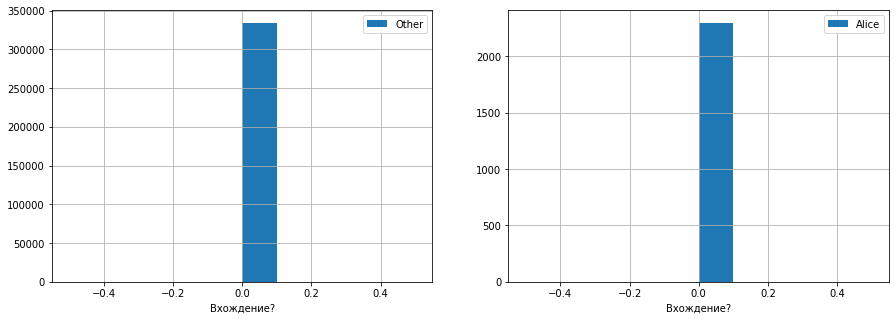

In [52]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
other.top20.hist(ax=ax1, label='Other')
alice.top20.hist(ax=ax2, label='Alice')
ax1.set_xlabel('Вхождение?')
ax2.set_xlabel('Вхождение?')
ax1.legend()
ax2.legend()

## 4. Development model

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
time_split = TimeSeriesSplit(n_splits=10)

Для решения задачи будем использовать логистическую регрессию. Поскольку это линейный метод классификации, то необходимо категориальные признаки закодировать по методу one-hot-encoding, а численные признаки, по возможности, отмасштабировать.

In [33]:
new_feature_enc = pd.get_dummies(new_feature, columns=[
#     'year',
    'day_part',
    'top20',
    'week_day',
#     'weekend',
#     'month',
#     'hour',
#     'len',
    'domain'
])

In [34]:
features_to_scale = [
    'hour',
#     'month',
#     'len',
#     'durations',
    'month_year',
#     'diff_time2_time1',
#     'diff_time3_time2',
#     'diff_time4_time3',
#     'diff_time5_time4',
#     'diff_time6_time5',
#     'diff_time7_time6',
#     'diff_time8_time7',
#     'diff_time9_time8',
#     'diff_time10_time9',
    
]
new_feature_enc[features_to_scale] = StandardScaler().fit_transform(new_feature_enc[features_to_scale])

Разделим на трейн и тест.

In [35]:
X_train_features = new_feature_enc.iloc[:train_df.shape[0],:]
X_test_features = new_feature_enc.iloc[train_df.shape[0]:,:]
y = train_df.target

Не все столбцы датафрейма будем использовать в своем решении

In [36]:
X_train_features.columns

Index(['target', 'sess_popular', 'len', 'hour', 'month', 'year', 'week',
       'month_year', 'weekend', 'durations',
       ...
       'domain_tw', 'domain_ua', 'domain_ug', 'domain_uk', 'domain_us',
       'domain_va', 'domain_vc', 'domain_vn', 'domain_ws', 'domain_za'],
      dtype='object', length=196)

Объеденим разреженную матрицу после CountVectorizer с новыми признаками

In [37]:
X_train_new = hstack([
    X_train_text,
    
#     X_train_features.day_part.astype('int').values.reshape(-1,1),
    X_train_features.day_part_0.astype('int').values.reshape(-1,1),
    X_train_features.day_part_1.astype('int').values.reshape(-1,1),
    X_train_features.day_part_2.astype('int').values.reshape(-1,1),
    X_train_features.day_part_3.astype('int').values.reshape(-1,1),
    
#     X_train_features.top20.astype('int').values.reshape(-1,1),
#     X_train_features.top20_0.astype('int').values.reshape(-1,1),
#     X_train_features.top20_1.astype('int').values.reshape(-1,1),
    
    X_train_features.hour.astype('int').values.reshape(-1,1),
    
#     X_train_features.week_day.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_0.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_1.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_2.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_3.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_4.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_5.astype('int').values.reshape(-1,1),
#     X_train_features.week_day_6.astype('int').values.reshape(-1,1),
    
    X_train_features.sess_popular.astype('int').values.reshape(-1,1),
#     X_train_features.weekend.astype('int').values.reshape(-1,1),
#     X_train_features.durations.astype('int').values.reshape(-1,1),
#     X_train_features.len.astype('int').values.reshape(-1,1),
#     X_train_features.year.astype('int').values.reshape(-1,1),
    X_train_features.month_year.astype('int').values.reshape(-1,1),
#     X_train_features.month.astype('int').values.reshape(-1,1),
    
#     X_train_features.diff_time2_time1.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time3_time2.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time4_time3.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time5_time4.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time6_time5.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time7_time6.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time8_time7.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time9_time8.astype('int').values.reshape(-1,1),
#     X_train_features.diff_time10_time9.astype('int').values.reshape(-1,1),
    
#     X_train_features.domain_com.astype('int').values.reshape(-1,1),
#     X_train_features.domain_fr.astype('int').values.reshape(-1,1),
#     X_train_features.domain_net.astype('int').values.reshape(-1,1),
    
])

In [38]:
X_train_new.shape

(253561, 50007)

## 5. Validation process

Будем производить процесс валидации методом кросс валидации по временным интервалам. Разбитий по интервалам - 10 отрезков. Результат валидации - усредненное значение ROC-AUC на всех фолдах

In [39]:
logit = LogisticRegression(C=1,random_state=42, solver='liblinear',penalty='l2')

In [40]:
cv_scores = cross_val_score(logit, X_train_new, y, cv=time_split, 
                            scoring='roc_auc')
print(f'Результат на валидации составил : {cv_scores.mean():.4f}')

Результат на валидации составил : 0.9243


Попытки.....

In [41]:
'''
Text + day_part cross-val: 0.896197
Text + day_part + top20 cross-val: 0.896156
Text + day_part + hour cross-val: 0.895136
Text + day_part + top20 + hour + week_day + sess_popular cross-val: 0.89838
Text + day_part + top20 + hour + week_day + sess_popular + weekend cross-val: 0.89180
Text + day_part + hour + week_day + sess_popular cross-val: 0.8958
Text + day_part + top20 + hour + week_day + sess_popular + duration cross-val: 0.89724
Text + day_part + top20 + hour + week_day + sess_popular + len cross-val: 0.891337

Only encoding:
Text + day_part cross-val: 0.915684
Text + day_part + top20 cross-val: 0.91618
Text + day_part + top20 + week_day cross-val: 0.91130
Text + day_part + top20 + week_day(week_end) + (hour + sess_popular) cross-val: 0.91461
Text + day_part + top20 + (hour + sess_popular) cross-val: 0.916617
Text + day_part + top20 + (hour) cross-val: 0.91608
Text + day_part + top20 + (hour + weekend) cross-val: 0.9122
Text + day_part + top20 + (hour + sess_popular + len) cross-val: 0.9114
Text + day_part + top20 + (hour + sess_popular + durations) cross-val: 0.91605
Text + day_part + top20 + (hour + sess_popular + year + month + month_year) cross-val: 0.5

Encoding and scaller:
Text + day_part + top20 + hour cross-val: 0.921846
Text + day_part + top20 + hour + (sess_popular) cross-val: 0.92216
Text + day_part + top20 + hour + (sess_popular) + durations cross-val: 0.921728
Text + day_part + top20 + hour + (sess_popular) + durations + month_year cross-val: 0.92187
Text + day_part + top20 + hour + (sess_popular) + month_year cross-val: 0.923896
Text + day_part + top20 + hour + (sess_popular) + month_year + (time_diff all) cross-val: 0.526
Text + day_part + top20 + hour + (sess_popular) + month_year + time_diff all cross-val: 0.920
Text + day_part + top20 + hour + (sess_popular) + month_year + time_diff2-1 cross-val: 0.92217
Text + day_part + top20 + hour + (sess_popular) + month_year + len cross-val: 0.9237
Text + day_part + hour + (sess_popular) + month_year cross-val: 0.9242
Text + day_part + hour + month_year cross-val: 0.9227
Text + day_part + (sess_popular) + month_year cross-val: 0.916
Text + day_part + hour + (sess_popular) cross-val: 0.9212
Text + day_part + hour + (sess_popular) + month_year + month cross-val: 0.9242
'''

'\nText + day_part cross-val: 0.896197\nText + day_part + top20 cross-val: 0.896156\nText + day_part + hour cross-val: 0.895136\nText + day_part + top20 + hour + week_day + sess_popular cross-val: 0.89838\nText + day_part + top20 + hour + week_day + sess_popular + weekend cross-val: 0.89180\nText + day_part + hour + week_day + sess_popular cross-val: 0.8958\nText + day_part + top20 + hour + week_day + sess_popular + duration cross-val: 0.89724\nText + day_part + top20 + hour + week_day + sess_popular + len cross-val: 0.891337\n\nOnly encoding:\nText + day_part cross-val: 0.915684\nText + day_part + top20 cross-val: 0.91618\nText + day_part + top20 + week_day cross-val: 0.91130\nText + day_part + top20 + week_day(week_end) + (hour + sess_popular) cross-val: 0.91461\nText + day_part + top20 + (hour + sess_popular) cross-val: 0.916617\nText + day_part + top20 + (hour) cross-val: 0.91608\nText + day_part + top20 + (hour + weekend) cross-val: 0.9122\nText + day_part + top20 + (hour + sess_p

Проведем поиск оптимального параметра С по сетке для логистической регрессии

In [42]:
from sklearn.model_selection import GridSearchCV
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_new, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

In [43]:
print(f' Лучший ROC-AUC: {logit_grid_searcher.best_score_:.4f}, при параметре {logit_grid_searcher.best_params_}')

 Лучший ROC-AUC: 0.9242, при параметре {'C': 0.21544346900318834}


Создание тестового датафрейма идентичного тренировочному

In [44]:
X_test_new = hstack([
    X_test_text,
    
    X_test_features.day_part_0.astype('int').values.reshape(-1,1),
    X_test_features.day_part_1.astype('int').values.reshape(-1,1),
    X_test_features.day_part_2.astype('int').values.reshape(-1,1),
    X_test_features.day_part_3.astype('int').values.reshape(-1,1),
    
#     X_test_features.top20_0.astype('int').values.reshape(-1,1),
#     X_test_features.top20_1.astype('int').values.reshape(-1,1),
    
    X_test_features.hour.astype('int').values.reshape(-1,1),

    X_test_features.sess_popular.astype('int').values.reshape(-1,1),
    X_test_features.month_year.astype('int').values.reshape(-1,1),
    
])

Проверка на совпадение размеров по столбцам

In [46]:
assert X_train_new.shape[1] == X_test_new.shape[1]

In [47]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Отправляем на Kaggle!

In [48]:
logit_test_pred = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred, 'submission_16.csv')

## 6. Выводы

В результате проекта были созданы важные признаки для идентификации Алисы среди других пользователей интернета, а так же обучена простая модель машинного обучения. Качествона валидации очень хорошо коррелирует с доской Лидеров на соревновании. Точность предсказаний составляет 0.93%. Есть куда улучшать модель: Попробовать более долгие по вычислениям методы машинного обучения на основе градиентного бустинга, нейронных сетей , а так же создание ансамбля моделей над простейшими базовыми. Но модель для продакшена должна быть достаточно простой и выдавать решение (ответ) быстро, поэтому остановимся на логистической регрессии.